In [1]:
from statsmodels.stats.proportion import proportion_confint
from Bio import AlignIO
from Bio import SeqIO
from Bio.Seq import Seq
from datetime import date
import datetime
import csv
import baltic as bt
import collections
# from Bio.Alphabet import IUPAC
# from pySankey.sankey import sankey
import math
import collections
import datetime as dt

import os
import csv
from Bio import SeqIO
import os
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
import scipy
import collections
import numpy as np
import pandas as pd
import datetime
from datetime import date

# import skbio
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.path as mpath
import matplotlib.lines as mlines
import collections
import matplotlib.patches as patches
import matplotlib.colors as mcolors
from matplotlib.patches import Polygon
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

from matplotlib.collections import PatchCollection
from epiweeks import Week, Year
font = {'family' : 'Helvetica',
        'weight' : 'bold',
        'size'   : 18}
from matplotlib.lines import Line2D

mpl.rcParams.update({'font.size': 25})

new_rc_params = {'text.usetex': False,
"svg.fonttype": 'none'
}
mpl.rcParams.update(new_rc_params)

plt.rcParams['font.family'] = 'Helvetica'

In [2]:
def get_node_states_all_sites(directory,state_file,alignment):
    
    #returns a dict keys off 1-based positions in the genome
    #and the value is a list of tuples (id, base) at a given node
    # allows you to look up for a given site what the base is for a
    #given internal node or tip
    
    node_states = collections.defaultdict(list)
    c = 0
    
    ## first the reconstructed nodes
    with open(f"{directory}/{state_file}","r") as f:
        for l in f:

            if not l.startswith("#"):
                c+=1
                try:
                    node,site,state,probA,probC,probG,probT = l.rstrip("\n").split("\t")
                except:
                    print(l)
                    break
                if node != "Node":
                    if state not in ["N","-"]:
                        node_states[site].append((node,state))
                    else:
                        node_states[site].append((node,""))
    ## now the tips
    for record in SeqIO.parse(f"{directory}/{alignment}","fasta"):
        for site in node_states:
            index = int(site)-1
            base = record.seq[index]
            if base in ["T","C","A","G"]:
                node_states[site].append((record.id,base))
            else:
                node_states[site].append((record.id,""))
                
    return node_states

def get_header_str(dict_values):
    header_str = ""
    for i in sorted(dict_values, key = lambda i : i[0]):
        header_str += f"{i[0]},"
    header_str = header_str.rstrip(",")
    return header_str
    
    
def find_what_sites_vary_unambiguously(node_states,outfile):
    header_str = get_header_str(node_states["1"])
    
    with open(outfile,"w") as fw:
        fw.write(f"site,{header_str}\n")

        for site in node_states:
            info = node_states[site]
            
            # get the set of unique bases at a given site
            count = set([i[1] for i in info if i[1]])
            
            #if there's more than one
            if len(count)>1:
                
                #needs to be kep consistent with header str
                info = sorted(info, key = lambda i : i[0])
                base_str = ""
                for i in info:
                    base_str += f"{i[1]},"
                    
                base_str = base_str.rstrip(",")
                fw.write(f"{site},{base_str}\n")
    
def load_unambiguous_varying_sites(infile):
    node_states_diff = collections.defaultdict(dict)
    with open(infile,"r") as f:
        reader = csv.DictReader(f)
        for row in reader:
            site = row["site"]
            for col in row:
                if col != "site":
                    node_states_diff[row["site"]][col] = row[col]
    return node_states_diff

def map_site_changes_to_branches(treefile, outfile,node_states,node_states_diff): 
    my_tree=bt.loadNewick(treefile,absoluteTime=False)
    last_node = ""
    current_node = ""

    with open(outfile,"w") as fw:
        fw.write("parent,child,site,snp,dimer\n")

        for k in my_tree.Objects:
            if k.branchType == 'leaf':
                current_node = k
                current_node.traits["label"]=k.name
            else:
                current_node = k

            if last_node:
                node_name = current_node.traits["label"]
                parent_name = current_node.parent.traits["label"]
                snps = []
                for site in node_states_diff:
                    node_base = node_states_diff[site][node_name]
                    parent_base = node_states_diff[site][parent_name]

                    if node_base != parent_base:
                        if node_base in ["A","C","G","T"] and parent_base in ["A","C","G","T"]:
                            snp = f"{parent_base}->{node_base}"
                            snps.append(snp)
                            if snp == "G->A":
                                dimer_site = f"{int(site)+1}"
                                dimer_base = ""

                                for i in node_states[dimer_site]:
                                    if i[0] == parent_name:
                                        dimer_base = i[1]
                                dimer = f"{parent_base}{dimer_base}"
                            elif snp == "C->T":
                                dimer_site = f"{int(site)-1}"
                                dimer_base = ""

                                for i in node_states[dimer_site]:
                                    if i[0] == parent_name:
                                        dimer_base = i[1]
                                dimer = f"{dimer_base}{parent_base}"
                            else:
                                dimer = ""
                            fw.write(f"{parent_name},{node_name},{site},{snp},{dimer}\n")

            last_node = current_node

def read_in_branch_snps(branch_snps):
    branch_snps_dict = collections.defaultdict(list)
    with open(branch_snps,"r") as f:
        reader = csv.DictReader(f)
        for row in reader:
            branch = f"{row['parent']}_{row['child']}"
            branch_snps_dict[branch].append((row['site'],row['snp'],row['dimer'])) 
    return branch_snps_dict

def get_branch_snps_sites(branch_snps):
    all_snps = collections.Counter()
    branch_snps_dict = collections.defaultdict(list)
    with open(branch_snps,"r") as f:
        reader = csv.DictReader(f)
        for row in reader:
            all_snps[int(row["site"])]+=1

            branch_snps_dict[int(row['site'])].append([row['parent'],row['child'],row['snp'],row['dimer']])
    
    homoplasies = {}
    for k in all_snps:
        if all_snps[k]>1:
            homoplasies[k] = all_snps[k]
            
    print(len(homoplasies))
    print(homoplasies)
    return branch_snps_dict,homoplasies
    

def get_acc_to_metadata_map(metadata):
    acc_dict = {}
    with open(metadata,"r") as f:
        reader = csv.DictReader(f)
        for row in reader:
            try:
                acc_dict[row["accession"]] = row
            except:
                try:
                    acc_dict[row["\ufeffaccession"]] = row
                except:
                    pass
                
    return acc_dict

In [16]:
def make_reconstruction_tree_figure(outfile,branch_snps,treefile,width,height):
    
    branch_snps_dict = read_in_branch_snps(branch_snps)
    print(len(branch_snps_dict),"snps")
#     acc_dict = get_acc_to_metadata_map(metadata)
#     print(len(acc_dict))        
    
    my_tree=bt.loadNewick(treefile,absoluteTime=False)

    fig,ax = plt.subplots(figsize=(width,height),facecolor='w')
    
    col_dict= col_dict= {
    'SLE': '#FF1294',
    'Nigeria': '#A412FF',
    'Togo': '#DAF7A6',
    'Ghana': '#FFBF00',
    'Germany': '#FFC0CB',
    'USA': '#239B56',
    'Guinea': '#0000FF'
    
}
    x_attr=lambda k: k.height ## x coordinate of branches will be absoluteTime attribute
    su_func=lambda k: 100-30*k.height/my_tree.treeHeight ## size of tips
    s_func=lambda k: 100-20*k.height/my_tree.treeHeight ## size of tips
    c_func=lambda k: col_dict[k.name.split('|')[-2]] if k.name.split('|')[-2] in col_dict else '#A412FF'

    increment = my_tree.treeHeight/150
    my_tree.plotTree(ax,x_attr=x_attr) ## plot branches
    my_tree.plotPoints(ax,size=s_func,colour=c_func,x_attr=x_attr) ## plot circles at tips
    mpl.rcParams['font.family'] = 'sans-serif'
    

    
    
    for k in my_tree.Objects:
        current_node = k
        if k.branchType == 'leaf':
            current_node.traits["label"]=k.name

        node_name = current_node.traits["label"]
        try:
            parent_name = current_node.parent.traits["label"]
        except:
            continue
        branch_name= f"{parent_name}_{node_name}"

        if branch_name in branch_snps_dict:
            snps = []
#                 print(branch_name, len(branch_snps_dict[branch_name]))
            snp_placement = current_node.parent.height + increment
            for s in branch_snps_dict[branch_name]:
                site,snp,dimer = s
                if snp == "G->A":
                    if dimer in ["GA"]:
                        snps.append((1,"#de1220"))
                    else:
                        snps.append((2,"#A9A9A9"))
                elif snp == "C->T":
                    if dimer in ["TC"]:
                        snps.append((1,"#de1220"))
                    else:
                        snps.append((2,"#A9A9A9"))
                else:
                    snps.append((2,"#A9A9A9"))

            for snp in sorted(snps, key = lambda x : x[0]):
                plt.scatter([snp_placement],[k.y+1.5],color=snp[1],s=30)
                snp_placement += increment

    [ax.spines[loc].set_visible(False) for loc in ['top','right','left','bottom']]
    ax.tick_params(axis='y',size=0)
    ax.tick_params(axis='x',size=0)

    ax.set_yticklabels([])
    ax.set_xticklabels([])

    plt.savefig(f"./{outfile}.svg");
    plt.savefig(f"./{outfile}.png",bbox_inches='tight', 
                   transparent=True);
    plt.show()

547 snps


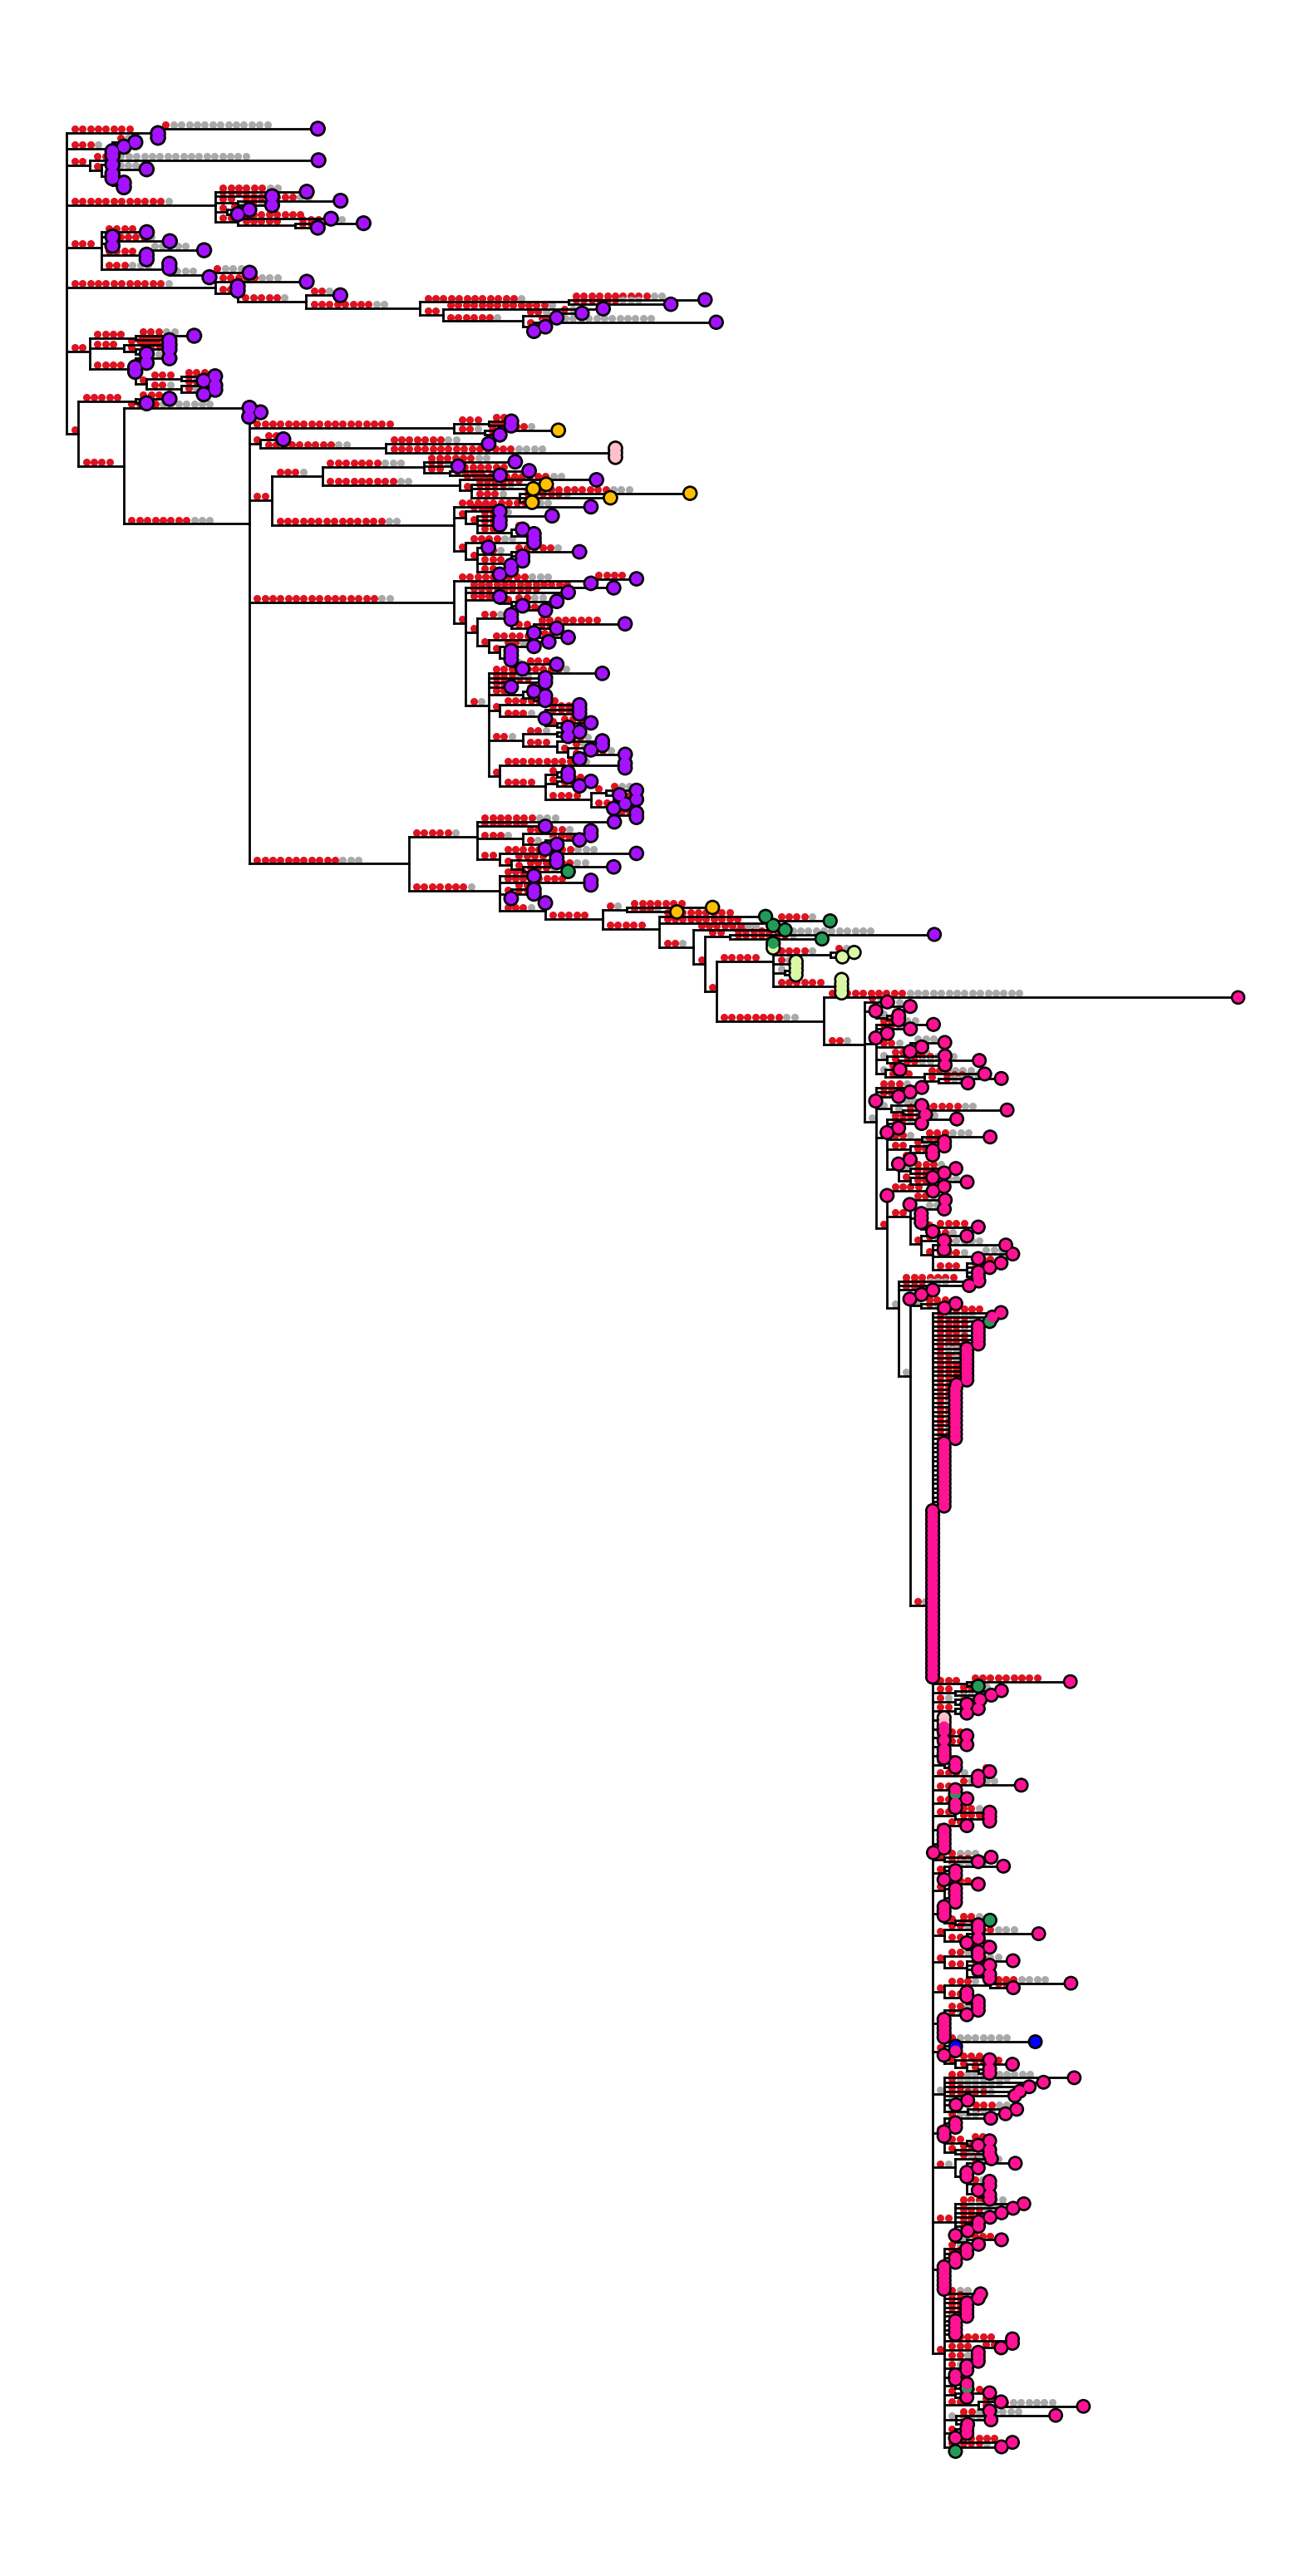

In [17]:
branch_snps = "/Volumes/Ifeanyi/SLE+2025-07-30/Complete_mpox_2025-08-03.aln.tree.branch_snps.reconstruction.csv"
treefile = "/Volumes/Ifeanyi/SLE+2025-07-30/Complete_mpox_2025-08-03.aln.tree"
make_reconstruction_tree_figure("completed_all_SLE.tree",branch_snps,treefile,20,40)

In [ ]:
branch_snps = "/Volumes/Ifeanyi/SLE+2025-07-30/ONLY+SLE/Complete_SLE+only.fasta.tree.branch_snps.reconstruction.csv"
treefile = "/Volumes/Ifeanyi/SLE+2025-07-30/ONLY+SLE/Complete_SLE+only.fasta.tree"
make_reconstruction_tree_figure("Complete_mpox-SLE_2025-08-05",branch_snps,treefile,1,25)

547 branches


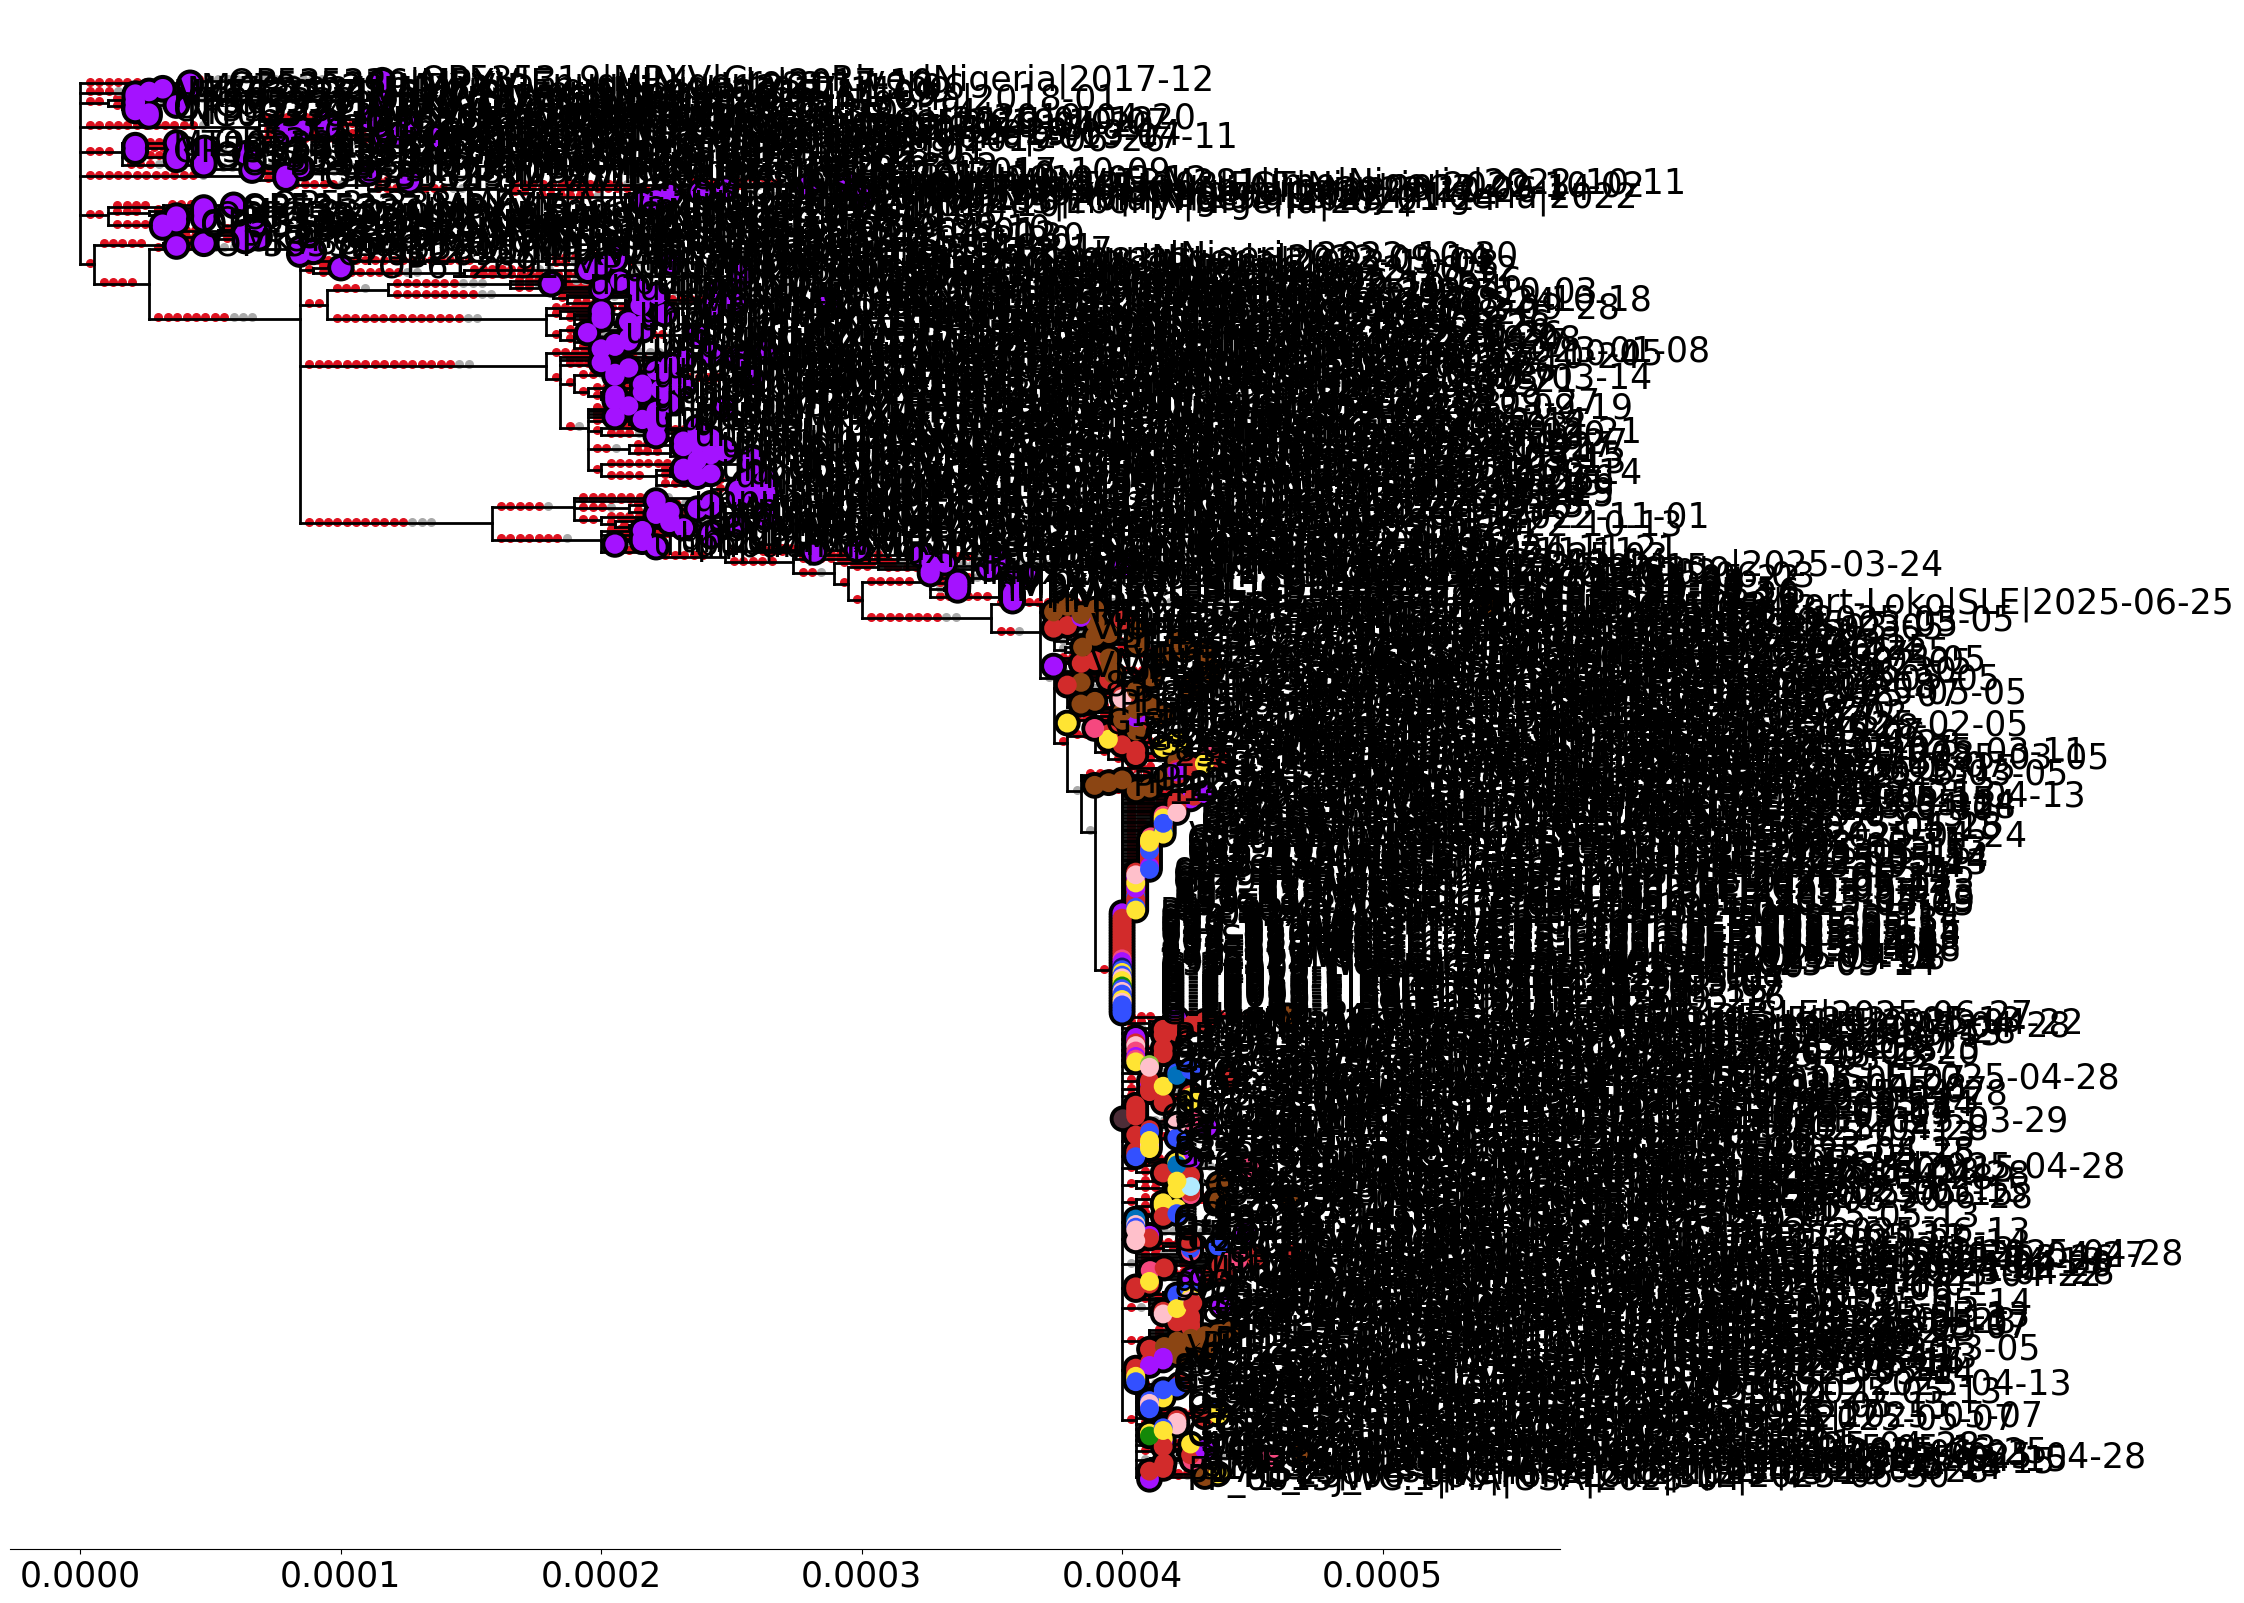

In [6]:

def make_reconstruction_tree_figure_w_labels(outfile,branch_snps,treefile,width,height):
    
    branch_snps_dict = read_in_branch_snps(branch_snps)
    print(len(branch_snps_dict),"branches")
#     acc_dict = get_acc_to_metadata_map(metadata)
#     print(len(acc_dict))        
    
    my_tree=bt.loadNewick(treefile,absoluteTime=False)

    fig,ax = plt.subplots(figsize=(width,height),facecolor='w')
    col_dict= {
    "Bo": "#3350FF",
    "Bonthe": "#FFC0CB",
    "Bombali":"black",
    "Kambia":"indianred",
    "Koinadugu": "#16166B",
    "Kailahun": "#0070BB",
    "Kenema": "#FFE433",
    "Kono": "#8cc63f",
    "Port-Loko": "#8B4513",
    "Pujehun": "#138808",
    "Tongo": "#4c2d37",
    "Tonkolili": "#b1eaff",
    "WesternRural": "#f5487f",
    "WesternUrban": "#D22B2B"
    
}

    x_attr=lambda k: k.height ## x coordinate of branches will be absoluteTime attribute
    su_func=lambda k: 200-30*k.height/my_tree.treeHeight ## size of tips
    s_func=lambda k: 200-20*k.height/my_tree.treeHeight ## size of tips
    c_func=lambda k: col_dict[k.name.split('|')[-3]] if k.name.split('|')[-3] in col_dict else '#A412FF'

    increment = my_tree.treeHeight/150
    my_tree.plotTree(ax,x_attr=x_attr) ## plot branches
    my_tree.plotPoints(ax,size=s_func,colour=c_func,x_attr=x_attr) ## plot circles at tips
    mpl.rcParams['font.family'] = 'sans-serif'
    
    
    target_func=lambda k: k.is_leaf() ## which branches will be annotated
    text_func=lambda k: k.name ## what text is plotted
    text_x_attr=lambda k: k.height+(increment*4) ## where x coordinate for text is

    my_tree.addText(ax,x_attr=text_x_attr,target=target_func,text=text_func) #
    
    for k in my_tree.Objects:
        current_node = k
        if k.branchType == 'leaf':
            current_node.traits["label"]=k.name

        node_name = current_node.traits["label"]
        try:
            parent_name = current_node.parent.traits["label"]
        except:
            continue
        branch_name= f"{parent_name}_{node_name}"

        if branch_name in branch_snps_dict:
            snps = []
#                 print(branch_name, len(branch_snps_dict[branch_name]))
            snp_placement = current_node.parent.height + increment
            for s in branch_snps_dict[branch_name]:
                site,snp,dimer = s
                if snp == "G->A":
                    if dimer in ["GA"]:
                        snps.append((1,"#de1220"))
                    else:
                        snps.append((3,"#A9A9A9"))
                elif snp == "C->T":
                    if dimer in ["TC"]:
                        snps.append((2,"#de1220"))
                    else:
                        snps.append((3,"#A9A9A9"))
                else:
                    snps.append((4,"#A9A9A9"))

            for snp in sorted(snps, key = lambda x : x[0]):
                plt.scatter([snp_placement],[k.y+0.5],color=snp[1],s=30)
                snp_placement += increment

    [ax.spines[loc].set_visible(False) for loc in ['top','right','left']]
    ax.tick_params(axis='y',size=0)
#     ax.tick_params(axis='x',size=0)

    ax.set_yticklabels([])
#     ax.set_xticklabels([])

    plt.savefig(f"./{outfile}.svg");
    plt.savefig(f"./{outfile}.png",bbox_inches='tight', 
                   transparent=True);
    plt.show()

branch_snps = "/Volumes/Ifeanyi/SLE+2025-07-30/Complete_mpox_2025-08-03.aln.tree.branch_snps.reconstruction.csv"
treefile = "/Volumes/Ifeanyi/SLE+2025-07-30/Complete_mpox_2025-08-03.aln.tree"
make_reconstruction_tree_figure_w_labels("completed_all_SLE.tree",branch_snps,treefile,20,20)

In [ ]:
# --- Legend with circle size 45 ---
    legend_elements = [
        Line2D([0],[0], marker='o', color='w', label='Context-dependent transition', 
               markerfacecolor='#de1220', markersize=np.sqrt(45)),
        Line2D([0],[0], marker='o', color='w', label='Other SNP', 
               markerfacecolor='#A9A9A9', markersize=np.sqrt(45))
    ]
    ax.legend(handles=legend_elements, frameon=False, loc='upper right', title='SNPs')
kenema=#FFE433
Pujehun=#138808
WAU=#D22B2B
porto-Loko=#8B4513
Bonthe=#FFC0CB

In [ ]:
import matplotlib.pyplot as plt

# Updated mapping
location_colors = {
    'SLE': '#FF1294',
    'Nigeria': '#A412FF',
    'Togo': '#DAF7A6',
    'Ghana': '#FFBF00',
    'Germany': '#FFC0CB',
    'USA': '#239B56',
    'Guinea': '#0000FF'
}

# Create vertical column of circles with labels
plt.figure(figsize=(4, 6))
plt.axis('off')

# y positions (top to bottom)
locations = list(location_colors.keys())
y_positions = range(len(locations))[::-1]

for y, loc in zip(y_positions, locations):
    plt.scatter([0], [y], s=45**2/4, marker='o', color=location_colors[loc])
    plt.text(0.1, y, loc, va='center')

plt.xlim(-0.2, 1)
plt.ylim(-1, len(locations))
plt.title("Location")
plt.show()


In [ ]:
import baltic as bt
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import gaussian_kde
import matplotlib.lines as mlines

# 1. Load tree and compute its vertical span
my_tree = bt.loadNexus(
    "/Volumes/Ifeanyi/CladeII_ML/ALL_SLE+CladeIIb.mcc.tree",
    tip_regex=r"\|(\d{4}(?:-\d{2})?(?:-\d{2})?)$",
    absoluteTime=True
)
my_tree.treeStats()
ymax = my_tree.ySpan

# 2. Load BEAST log and drop burn‑in
df = pd.read_csv("/Volumes/Ifeanyi/CladeII_ML/1ALL_SLE+CladdeIIb.log", sep="\t")
burnin = int(len(df) * 0.20)
df = df.iloc[burnin:].reset_index(drop=True)

# 3. Compute scaling for densities
def kde_peak(data):
    kde = gaussian_kde(data)
    xs = np.linspace(data.min(), data.max(), 500)
    return kde(xs).max()

peak_sle  = kde_peak(df["age(SLE)"])
peak_stem = kde_peak(df["age(stemSLE)"])
peak_frac = 0.20  # density height = 20% of tree height

scale_sle  = (ymax * peak_frac) / peak_sle
scale_stem = (ymax * peak_frac) / peak_stem

# 4. Prepare grid for KDE curves
min_year, max_year = 2015, 2026
xs = np.linspace(min_year, max_year, 500)
kde_sle  = gaussian_kde(df["age(SLE)"])
ys_sle   = kde_sle(xs) * scale_sle
kde_stem = gaussian_kde(df["age(stemSLE)"])
ys_stem  = kde_stem(xs) * scale_stem

# 5. Start plotting
fig, ax = plt.subplots(figsize=(15, 15), facecolor='w')

# 5a. Shaded year bands
for i, yr in enumerate(range(min_year, max_year)):
    if i % 2 == 0:
        ax.axvspan(yr, yr+1, color='k', alpha=0.05, zorder=0)

# 5b. Plot densities at the base (zorder=1)
ax.fill_between(xs, 0, ys_sle,
                color='black', alpha=0.3,
                label='age(SLE) density', zorder=1)
ax.fill_between(xs, 0, ys_stem,
                color='#0070BB', alpha=0.3,
                label='age(stemSLE) density', zorder=1)

# 5c. Now overlay the tree (higher zorder)
s_func  = lambda k: 100
x_attr  = lambda k: k.absoluteTime
col_dict = {
    'SLE':'#FF1294','Nigeria':'#A412FF','Togo':'#DAF7A6',
    'Ghana':'#FFBF00','Germany':'#FFC0CB','USA':'#239B56',
    'Guinea':'#0000FF','Rest':'#C0C0C0','Unknown':'black'
}
c_func = lambda k: col_dict.get(k.name.split('|')[-2], col_dict['Rest'])

my_tree.plotTree(ax,   x_attr=x_attr, zorder=2)
my_tree.plotPoints(ax, size=s_func, colour=c_func, x_attr=x_attr, zorder=3)

# 6. Vertical lines & annotations
for x_val, txt, ls, col in [
    (2024.611, "Established Transmission", ":", "#16166F"),
    (2023.159, "tMRCA Introduction",       "--", "black")
]:
    ax.axvline(x_val,
               ymin=0, ymax=0.6,
               linestyle=ls, linewidth=3,
               color=col,
               zorder=4)
    ax.text(x_val - 0.3,
            ymax * 0.03,
            txt,
            fontsize=30,
            rotation=90,
            verticalalignment='bottom',
            zorder=4)

# 7. Legend with "Sierra Leone" label
label_map = {
    'SLE': 'Sierra Leone',
    'Nigeria': 'Nigeria',
    'Togo': 'Togo',
    'Ghana': 'Ghana',
    'Germany': 'Germany',
    'USA': 'USA',
    'Guinea': 'Guinea',
    'Rest': 'Rest',
    'Unknown': 'Unknown'
}

legend_handles = [
    mlines.Line2D([], [], color=col, marker='o', markersize=25,
                  linestyle='None', label=label_map[key])
    for key, col in col_dict.items()
]

leg = ax.legend(handles=legend_handles,
                ncol=1,
                frameon=False,
                bbox_to_anchor=(0.5, 0.5),
                prop={'size': 20},
                facecolor='w')
leg.set_zorder(5)


ax.set_xlim(min_year, max_year)
ax.set_ylim(-0.5, ymax)  # show the full tree height

ax.tick_params(axis='y', left=False, labelleft=False)
ax.tick_params(axis='x', labelsize=45)
for spine in ['top','right','left']:
    ax.spines[spine].set_visible(False)

ax.set_xlabel("",)
plt.tight_layout()
plt.savefig("/Volumes/Ifeanyi/CladeII_ML/SLE_tree_with_embedded_density_full.png", dpi=300, bbox_inches='tight'),
plt.savefig("/Volumes/Ifeanyi/CladeII_ML/SLE_tree_with_embedded_density_full.pdf", dpi=300, bbox_inches='tight')
plt.savefig("/Volumes/Ifeanyi/CladeII_ML/SLE_tree_with_embedded_density_full.svg", dpi=300, bbox_inches='tight')

plt.show()


In [ ]:
df = pd.read_csv("/Volumes/Ifeanyi/CladeII_ML/SKD.txt",sep="\t",skiprows=[0])
df["time"] = pd.to_numeric(df["time"])

df2 = pd.read_csv("/Volumes/Ifeanyi/CladeII_ML/EXP.txt",sep="\t",skiprows=[0])
df2["time"] = pd.to_numeric(df2["time"])


fig,ax= plt.subplots(figsize=(25,20),facecolor='w',frameon=False)

sns.lineplot(data=df2, x=df2["time"],y=df2["mean"],linewidth=5,color="black",linestyle="--",  label="Exponential growth")
plt.fill_between(df2["time"],df2["upper"],df2["lower"],alpha=0.2,color="black")

sns.lineplot(data=df, x=df["time"],y=df["mean"],linewidth=5,color="#4682B4",label="Skygrid")
plt.fill_between(df["time"],df["upper"],df["lower"],alpha=0.5,color="#4682B4")

plt.ylim(-1)


plt.yscale("log")
plt.ylabel("Effective population size (years)", fontsize=45)
plt.xlabel("Year", fontsize=45)

ax.tick_params(axis='x', size=10, width=15, color='grey')

x = df2['upper'].max()
n = df['lower'].min()
plt.ylim(n,x)
tx = df2['time'].max()
tn = df['time'].min()
plt.xlim(tn,tx)


print(x, n)
print(tn,tx)
plt.legend(frameon=False,loc="upper left", fontsize=55,  prop={'size': 60})


# Assuming 'ax' is your Axes object
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Set the linewidth of the bottom and left spines
ax.spines['bottom'].set_linewidth(3.2)
ax.spines['left'].set_linewidth(3.2)
plt.yticks(fontsize=55)
plt.xticks(fontsize=55)
fig.tight_layout(pad=0.65)    
plt.savefig("/Volumes/Ifeanyi/CladeII_ML/SLE+corrected_skygrid_vs_epoch_exponential.svg");
plt.savefig("/Volumes/Ifeanyi/CladeII_ML/SLE+corrected_skygrid_vs_epoch_exponential.png");
plt.savefig("/Volumes/Ifeanyi/CladeII_ML/SLE+corrected_skygrid_vs_epoch_exponential.pdf");
plt.show();

In [ ]:
from datetime import datetime, timedelta

def decimal_year_to_date(decimal_year):
    """Convert a decimal year to an actual date."""
    year = int(decimal_year)  # Extract the year part
    remainder = decimal_year - year  # Get the decimal part
    start_of_year = datetime(year, 1, 1)  # January 1st of that year
    next_year = datetime(year + 1, 1, 1)  # January 1st of the following year
    days_in_year = (next_year - start_of_year).days  # Total days in the year
    date = start_of_year + timedelta(days=(remainder * days_in_year))
    return date.date()  # Return as a date object

# Example decimal year to convert
decimal_year = 2024.606

# HPD interval
hpd_interval = [2024.3398, 2024.7251]

# Convert decimal year to actual date
date = decimal_year_to_date(decimal_year)

# Convert the HPD interval to actual dates
hpd_start = decimal_year_to_date(hpd_interval[0])
hpd_end = decimal_year_to_date(hpd_interval[1])

# Print the results
print(f"Decimal year {decimal_year} corresponds to {date}")
print(f"HPD interval [{hpd_interval[0]}, {hpd_interval[1]}] corresponds to [{hpd_start}, {hpd_end}]")



In [ ]:
earliest_node = 100000000
for k in my_tree.Objects:
    if k.absoluteTime < earliest_node:
        earliest_node = k.absoluteTime
        
print(earliest_node)

for k in my_tree.Objects:
    if k.absoluteTime == earliest_node:
        print(k)
        print(k.childHeight)
        midpt = (k.yRange[0] + k.yRange[1]) / 2
        print(k.yRange, midpt)

In [ ]:
import baltic as bt
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import gaussian_kde
import math
import seaborn as sns

# 1. Load BEAST log and drop burn‑in
# Use `comment="#"` to ignore any header or comment lines starting with "#"
df2 = pd.read_csv(
    "/Volumes/Ifeanyi/CladeII_ML/ALL_SLE+CladdeIIb.log",
    sep="\t",
    comment="#"   # <── this skips all lines starting with #
)

# Apply burn‑in (e.g., discard the first 10%)
burnin = int(len(df2) * 0.10)
df2 = df2.iloc[burnin:].reset_index(drop=True)

# 2. Doubling time (years → weeks)
def return_doubling_time(rate):
    return math.log(2) / rate

df2["doubling_time_weeks"] = df2["expSLE.growthRate"].map(return_doubling_time) * 52

# 2a. Compute mean and 95% HPD
dt = df2["doubling_time_weeks"].values
mean_dt = dt.mean()

def hpd(data, alpha=0.05):
    sorted_data = np.sort(data)
    n = len(sorted_data)
    k = int(np.floor((1.0 - alpha) * n))
    intervals = sorted_data[k:] - sorted_data[:n - k]
    min_idx = np.argmin(intervals)
    return sorted_data[min_idx], sorted_data[min_idx + k]

hpd_low, hpd_high = hpd(dt, alpha=0.05)

print(f"Mean doubling time: {mean_dt:.2f} weeks")
print(f"95% HPD interval: [{hpd_low:.2f}, {hpd_high:.2f}] weeks")

# 3. Plot KDE of doubling time (weeks)
fig, ax = plt.subplots(figsize=(25, 20), facecolor='w', frameon=False)

sns.kdeplot(
    data=df2,
    x="doubling_time_weeks",
    cut=0,
    fill=True,
    linewidth=2,
    label="Doubling time"
)

# 4. Styling
plt.legend(frameon=False, fontsize=30)
ax.set_xlim(0, df2["doubling_time_weeks"].quantile(0.99))
ax.set_xlabel("Doubling time (weeks)", fontsize=45)
ax.set_ylabel("", fontsize=0)
plt.xticks(fontsize=45)
plt.yticks(fontsize=35)
[ax.spines[loc].set_visible(False) for loc in ['top', 'right']]
plt.setp(ax.spines.values(), lw=3.2)
plt.tight_layout(pad=0.65)

# Save
plt.savefig("/Volumes/Ifeanyi/CladeII_ML/SLE+Doubling_time.svg")
plt.savefig("/Volumes/Ifeanyi/CladeII_ML/SLE+Doubling_time.png")
plt.savefig("/Volumes/Ifeanyi/CladeII_ML/SLE+Doubling_time.pdf")
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from datetime import datetime as dt
import time

# Helper to convert decimal year → datetime
def fracyear_to_datetime(fyear):
    year = int(fyear)
    remainder = fyear - year
    start_of_year = dt(year, 1, 1)
    # account for leap years
    days_in_year = 366 if (year % 4 == 0 and (year % 100 != 0 or year % 400 == 0)) else 365
    return start_of_year + pd.to_timedelta(remainder * days_in_year, unit='D')

# ─────────────────────────────────────────────
# Load data
# ─────────────────────────────────────────────
df = pd.read_csv("/Volumes/Ifeanyi/CladeII_ML/SKD.txt", sep="\t", skiprows=[0])
df["time"] = pd.to_numeric(df["time"])
df2 = pd.read_csv("/Volumes/Ifeanyi/CladeII_ML/EXP.txt", sep="\t", skiprows=[0])
df2["time"] = pd.to_numeric(df2["time"])

# Convert decimal years to datetime
df["date"] = df["time"].apply(fracyear_to_datetime)
df2["date"] = df2["time"].apply(fracyear_to_datetime)

# ─────────────────────────────────────────────
# Plot
# ─────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(25, 20), facecolor='w', frameon=False)

# Exponential growth
sns.lineplot(data=df2, x="date", y="mean",
             linewidth=5, color="black", linestyle="--", label="Exponential growth")
plt.fill_between(df2["date"], df2["upper"], df2["lower"], alpha=0.2, color="black")

# Skygrid
sns.lineplot(data=df, x="date", y="mean",
             linewidth=5, color="#4682B4", label="Skygrid")
plt.fill_between(df["date"], df["upper"], df["lower"], alpha=0.5, color="#4682B4")

# Set y limits
x = df2['upper'].max()
n = df['lower'].min()
plt.ylim(n, x)

# Set x limits
tx = df2['date'].max()
tn = df['date'].min()
plt.xlim(tn, tx)

# Log scale for y
plt.yscale("log")

# Labels
plt.ylabel("Effective population size (years)", fontsize=45)
plt.xlabel("Time (Year-Month)", fontsize=45)

# X-axis as Year-Month
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # tick every 3 months
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=0, ha='right', fontsize=55)

# Y-axis styling
plt.yticks(fontsize=55)

# Spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(3.2)
ax.spines['left'].set_linewidth(3.2)

# Legend
plt.legend(frameon=False, loc="lower center", fontsize=55, prop={'size': 60})

fig.tight_layout(pad=0.65)
# To save:
plt.savefig("/Volumes/Ifeanyi/CladeII_ML/SLE+corrected_skygrid_vs_epoch_exponential.svg");
plt.savefig("/Volumes/Ifeanyi/CladeII_ML/SLE+corrected_skygrid_vs_epoch_exponential.png");
plt.savefig("/Volumes/Ifeanyi/CladeII_ML/SLE+corrected_skygrid_vs_epoch_exponential.pdf");
plt.show()